# Grammatical Error Detection

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

import torch

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from helper import encode, get_param_info, flat_accuracy, flat_precision, flat_recall, flat_f1, format_time

## Loading BERT Tokenizer

In [2]:
# !pip install transformers

# load the BERT Tokenizer
print('Load BERT Tokenizer')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Load BERT Tokenizer


## Checking for GPUs

In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


## Loading the Datasets

In [5]:
train_df = pd.read_csv("tfug_pune_data/train.csv")
# eval_df  = pd.read_csv("data/val_data.csv")
test_df  = pd.read_csv("tfug_pune_data/test.csv")

train_df

,id,text_1,text_2,label
0,0,What is the German basic law?,The German Basic Law provides that no amendmen...,0
1,1,When did Nintendo release a cleaning kit?,"In 1989, Nintendo released an official NES Cle...",0
2,2,Nelson Beavers is a co-owner of the current co...,Nelson Beaver is staff at Carolina Analytical ...,1
3,3,and uh i'm originally from Virginia and uh and...,I'm from Virginia and I remember summers being...,0
4,4,Where is Space Center Houston?,Space Center Houston is the official visitors'...,0
...,...,...,...,...
9995,9995,When asked about the Bible's literal account o...,Every republican presidential candidate has tr...,0
9996,9996,"Three of its five permanent members, France, R...",China is a member of the U.N. Security Council.,0
9997,9997,What was the newer county added to the list?,"In 1999, the Times added a newer county—Imperi...",0
9998,9998,The connotation of gifted artistic performance...,The connotation of gifted artistic performance...,2


## Sample Sentences from Train Dataset

In [5]:
sentences = train_df.input.values
labels    = train_df.labels.values

In [6]:
# print the original sentence
print(' Original: ', sentences[0])

# Print the sentence split into tokens
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped into token ids
print("Token ids: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  I am reading score of Mahler is Symphony No . .
Tokenized:  ['i', 'am', 'reading', 'score', 'of', 'ma', '##hler', 'is', 'symphony', 'no', '.', '.']
Token ids:  [1045, 2572, 3752, 3556, 1997, 5003, 13620, 2003, 6189, 2053, 1012, 1012]


## Encoding the Sentences and Labels for BERT

In [7]:
# train sentences and labels
train_sentences = train_df.input.values
train_labels = train_df.labels.values

# encoding train sentences and labels
t_input_ids, t_attention_masks, t_labels = encode(tokenizer, train_sentences, train_labels, test=False)

# validation sentences and labels
eval_sentences = eval_df.input.values
eval_labels = eval_df.labels.values

# encoding validation sentences and labels
v_input_ids, v_attention_masks, v_labels = encode(tokenizer, eval_sentences, eval_labels, test=False)


# Print sentence 0, now as a list of Ids
print('Original: ', train_sentences[0])
print('Token IDs: ',  t_input_ids[0])

print('Original: ', eval_sentences[0])
print('Token IDs: ', v_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\siddh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  I am reading score of Mahler is Symphony No . .
Token IDs:  tensor([  101,  1045,  2572,  3752,  3556,  1997,  5003, 13620,  2003,  6189,
         2053,  1012,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0, 

## Preparing Dataset for Encoded Training and Validation Sets

In [8]:
t_dataset = TensorDataset(t_input_ids, t_attention_masks, t_labels)
v_dataset = TensorDataset(v_input_ids, v_attention_masks, v_labels)

print(len(t_dataset))
print(len(v_dataset))

19998
10000


## DataLoader for Training and Validation Sets

In [9]:
# For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            t_dataset,  # The training samples.
            sampler = RandomSampler(t_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            v_dataset, # The validation samples.
            sampler = SequentialSampler(v_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Load BERTForSequenceClassification
pretrained BERT model with a single linear classification layer on top

In [10]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # For binary classification   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Get all of the model's parameters as a list of tuples.

In [11]:
get_param_info(model, model.named_parameters())

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## AdamW optimizer is used 
Recommended by the Hugginface library

In [12]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


C:\Users\siddh\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Learning Rate Scheduler

In [13]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training and Evaluation of the Model

In [14]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = outputs[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # No need to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss, logits = outputs[:2]
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate all the evaluation metrics for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy  += flat_accuracy(logits, label_ids)
        total_eval_precision += flat_precision(logits, label_ids)
        total_eval_recall    += flat_recall(logits, label_ids)
        total_eval_f1        += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    # Report the final precision for this validation run.
    avg_val_precision = total_eval_precision / len(validation_dataloader)
    print("  Precision: {0:.2f}".format(avg_val_precision))
    
    # Report the final recall for this validation run.
    avg_val_recall = total_eval_recall / len(validation_dataloader)
    print("  Recall: {0:.2f}".format(avg_val_recall))
    
    # Report the final f1 score for this validation run.
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  F1 Score: {0:.2f}".format(avg_val_f1))

    
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accuracy': avg_val_accuracy,
            'Valid. Precision': avg_val_precision,
            'Valid. Recall': avg_val_recall,
            'Valid. F1 Score': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:14.
  Batch    80  of    625.    Elapsed: 0:00:25.
  Batch   120  of    625.    Elapsed: 0:00:35.
  Batch   160  of    625.    Elapsed: 0:00:46.
  Batch   200  of    625.    Elapsed: 0:00:57.
  Batch   240  of    625.    Elapsed: 0:01:07.
  Batch   280  of    625.    Elapsed: 0:01:18.
  Batch   320  of    625.    Elapsed: 0:01:29.
  Batch   360  of    625.    Elapsed: 0:01:40.
  Batch   400  of    625.    Elapsed: 0:01:50.
  Batch   440  of    625.    Elapsed: 0:02:01.
  Batch   480  of    625.    Elapsed: 0:02:12.
  Batch   520  of    625.    Elapsed: 0:02:23.
  Batch   560  of    625.    Elapsed: 0:02:34.
  Batch   600  of    625.    Elapsed: 0:02:45.

  Average training loss: 0.66
  Training epoch took: 0:02:51

Running Validation...
  Accuracy: 0.61
  Precision: 0.57
  Recall: 0.83
  F1 Score: 0.67
  Validation Loss: 0.64
  Validation took: 0:00:26

======== Epoch 2 / 4 ========
Training...
  Batc

## Saving Pretrained Model

In [15]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

## Loading Saved Tokenizer and Model

In [16]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


## Displaying the Results

In [17]:
# Display floats with two decimal places.
pd.set_option('display.precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accuracy,Valid. Precision,Valid. Recall,Valid. F1 Score,Training Time,Validation Time
epoch,,,,,,,,
1,0.658,0.644,0.606,0.574,0.829,0.672,0:02:51,0:00:26
2,0.608,0.659,0.593,0.562,0.856,0.672,0:02:50,0:00:26
3,0.555,0.722,0.584,0.557,0.836,0.662,0:02:51,0:00:26
4,0.515,0.803,0.575,0.553,0.787,0.644,0:02:51,0:00:26


## Plotting the Training and Validation Loss

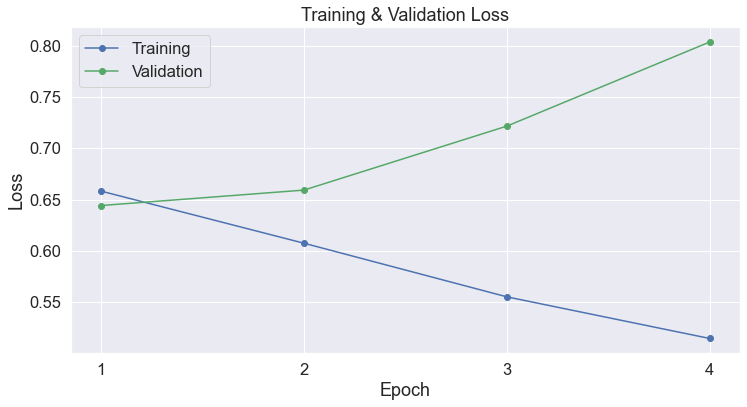

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

The Validation Loss starts increasing while Training Loss decreases showing that the model is overtraining.

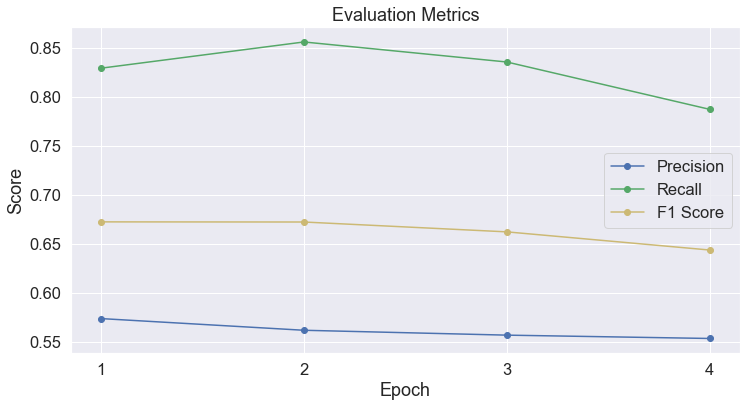

In [28]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Valid. Precision'], 'b-o', label="Precision")
plt.plot(df_stats['Valid. Recall'], 'g-o', label="Recall")
plt.plot(df_stats['Valid. F1 Score'], 'y-o', label="F1 Score")

# Label the plot.
plt.title("Evaluation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Encoding the Test Dataset

In [21]:
# test sentences
test_sentences = test_df.input.values

    
# encoding test sentences and labels
te_input_ids, te_attention_masks = encode(tokenizer, test_sentences, _, test=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\siddh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
len(te_input_ids)

9972

In [23]:
len(te_attention_masks)

9972

# Predicting the Values

In [24]:
values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for input_id, attention_mask in zip(te_input_ids, te_attention_masks):
    
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    values.append(index.item())

## Loading Sample Submission

In [25]:
sample_sub = pd.read_csv("data/sample_submission.csv")
sample_sub

,input,labels
0,I believe they will master english soon,0
1,I am looking for it . Thank so u much.,1
2,Tomato is a round fruit with smooth and colorf...,0
3,Let It Will Be Push and Go.,0


## Final Submission

In [26]:
final_submission = pd.DataFrame({"input": test_df.input.values, "labels": values})

final_submission

,input,labels
0,I believe they will master Japanese soon becau...,1
1,I am looking for it .,1
2,Apple is a round fruit with smooth and colorfu...,0
3,Let It Will Be Push .,0
4,I rode on this ship from Sendai .,0
...,...,...
9967,Lang is growing up and improving step by step !,1
9968,I was away from my housework for about days .,1
9969,The conflict is so serious .,1
9970,An apple is a round fruit with smooth and colo...,1


In [29]:
final_submission.to_csv("siddharth_singh_submission.csv")

## Sources - 

    1) https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    2) Natural Language Processing with Transformers, Lewis Tunstall (Chapter02 - Text Classification)
